# Project 2: Ames Housing Data and Kaggle Challenge
> By: Matthew Lio
---


Project notebook organisation:

# Preprocessing and Feature Engineering
---

## Library Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import patsy

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.dummy import DummyRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../datasets/train.csv')

In [3]:
# make columns lowercase and replacing spaces with underscores
train.columns = train.columns.str.lower()
train.columns = train.columns.str.replace(' ', '_')

In [4]:
train.head(10)

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
0   109  533352170           60        RL           NaN     13517   Pave   
1   544  531379050           60        RL          43.0     11492   Pave   
2   153  535304180           20        RL          68.0      7922   Pave   
3   318  916386060           60        RL          73.0      9802   Pave   
4   255  906425045           50        RL          82.0     14235   Pave   
5   138  535126040           20        RL         137.0     16492   Pave   
6  2827  908186070          180        RM          35.0      3675   Pave   
7   145  535154050           20        RL           NaN     12160   Pave   
8  1942  535353130           20        RL           NaN     15783   Pave   
9  1956  535426130           60        RL          70.0     11606   Pave   

  alley lot_shape land_contour utilities lot_config land_slope neighborhood  \
0   NaN       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1   NaN       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2   NaN       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3   NaN       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   
5   NaN       IR1          Lvl    AllPub     Corner        Gtl        NAmes   
6   NaN       Reg          Lvl    AllPub     Inside        Gtl      Edwards   
7   NaN       IR1          Lvl    AllPub     Inside        Gtl        NAmes   
8   NaN       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
9   NaN       IR1          HLS    AllPub     Inside        Sev        NAmes   

  condition_1 condition_2 bldg_type house_style  overall_qual  overall_cond  \
0        RRAe        Norm      1Fam      2Story             6             8   
1        Norm        Norm      1Fam      2Story             7             5   
2        Norm        Norm      1Fam      1Story             5             7   
3        Norm        Norm      1Fam      2Story             5             5   
4        Norm        Norm      1Fam      1.5Fin             6             8   
5        PosA        Norm      1Fam      1Story             6             6   
6        Norm        Norm    TwnhsE      SFoyer             6             5   
7        Norm        Norm      1Fam      1Story             5             5   
8      Artery        Norm      1Fam      1Story             5             5   
9        Norm        Norm      1Fam      2Story             5             5   

   year_built  year_remod/add roof_style roof_matl exterior_1st exterior_2nd  \
0        1976            2005      Gable   CompShg      HdBoard      Plywood   
1        1996            1997      Gable   CompShg      VinylSd      VinylSd   
2        1953            2007      Gable   CompShg      VinylSd      VinylSd   
3        2006            2007      Gable   CompShg      VinylSd      VinylSd   
4        1900            1993      Gable   CompShg      Wd Sdng      Plywood   
5        1966            2002      Gable   CompShg      BrkFace      Plywood   
6        2005            2006      Gable   CompShg      VinylSd      VinylSd   
7        1959            1959        Hip   CompShg      Plywood      Plywood   
8        1952            1952      Gable   CompShg      Wd Sdng      Wd Sdng   
9        1969            1969      Gable   CompShg      Plywood      Plywood   

  mas_vnr_type  mas_vnr_area exter_qual exter_cond foundation bsmt_qual  \
0      BrkFace         289.0         Gd         TA     CBlock        TA   
1      BrkFace         132.0         Gd         TA      PConc        Gd   
2         None           0.0         TA         Gd     CBlock        TA   
3         None           0.0         TA         TA      PConc        Gd   
4         None           0.0         TA         TA      PConc        Fa   
5         None           0.0         Gd         TA     CBlock        TA   
6      BrkFace        

## Preprocessing and Cleaning

### Dropping unnecessary columns

In [5]:
# function for dropping columns
def drop_col(df, cols_to_drop):
    df.drop(cols_to_drop, axis = 1, inplace = True)

In [6]:
to_drop = ['pid', 'street', 'alley', 'land_contour', 'utilities', 'land_slope',
           'condition_2', 'overall_cond', 'roof_matl', 'exter_cond',
           'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'heating', '1st_flr_sf',
           '2nd_flr_sf', 'bsmt_half_bath', 'totrms_abvgrd','garage_yr_blt',
           'garage_cars', 'garage_cond', 'pool_qc', 'misc_val', 'mo_sold', 'sale_type']

drop_col(train, to_drop)

### Converting numerical to categorical

In [7]:
# function for converting numerical to categorical
def convert_to_categorical(df, cols_to_convert):
    for i in cols_to_convert:
        df[i] = df[i].astype(str)

In [8]:
to_cat = ['ms_subclass']

convert_to_categorical(train, to_cat)

### Converting ordinal categorical values to ordinal numeric

In [9]:
# function for converting ordinal categorical to ordinal numeric
def to_ordinal_numeric(df, colname, dictionary):
    df[colname] = df[colname].map(dictionary)

In [10]:
def heatmap(df, cols, width = 5, height = 4):
    plt.figure(figsize=(width,height))
    mask = np.zeros_like(df[cols].corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(df[cols].corr(), annot=True, cmap = 'coolwarm', 
                mask = mask, vmin=-1, vmax=1);

In [11]:
# function to plot histogram and boxplot for all categorical variables
def categorical_col_plots(df, col_list):
    nrows = len(col_list)
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize=(20, nrows*5))
    ax = ax.ravel()
    for i, col in enumerate(col_list):
        sns.histplot(df[col], ax = ax[i*2-2])
        ax[i*2-2].set_title(f'{col} distribution',fontsize=14)
        ax[i*2-2].tick_params(labelsize=12)
        ax[i*2-2].set_xlabel(col, fontsize=14)
        
        sns.boxplot(x = df[col], y = df['saleprice'], ax = ax[i*2-1])
        ax[i*2-1].set_title(f'{col} vs saleprice',fontsize=14)
        ax[i*2-1].tick_params(labelsize=12)
        ax[i*2-1].set_xlabel(col, fontsize=14)
        
    plt.tight_layout()

In [12]:
# function to plot histogram, boxplot and scatterplot for all numerical variables
def numeric_col_plots(df, col_list):
    nrows = len(col_list)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(20, nrows*5))
    ax = ax.ravel()
    for i, col in enumerate(col_list):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} boxplot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        sns.regplot(data=df, x=df[col], y=df['saleprice'],ax = ax[i*3-1],
                    scatter_kws={'edgecolor':'white'}, line_kws = {'color':'grey'})
        ax[i*3-1].set_title(f'{col} vs saleprice', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
        
    plt.tight_layout()

#### `lot_shape`

In [13]:
lot_shape_dict = {'Reg': 0,
                  'IR1': 1,
                  'IR2': 2,
                  'IR3': 3}

to_ordinal_numeric(train, 'lot_shape', lot_shape_dict)

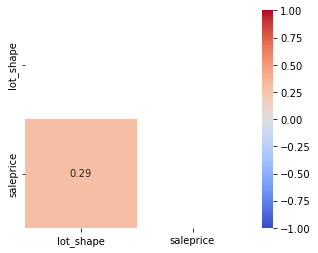

In [14]:
heatmap(train, ['lot_shape', 'saleprice'])

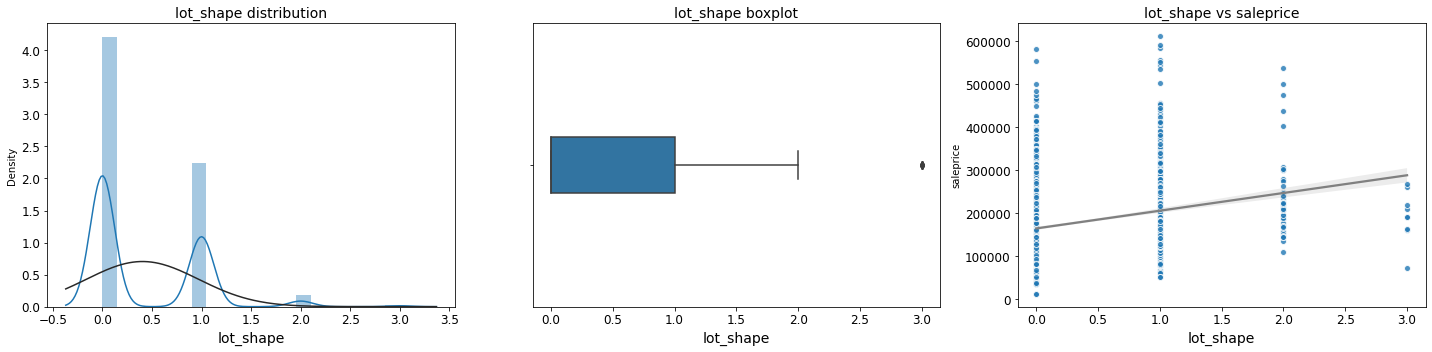

In [15]:
numeric_col_plots(train, ['lot_shape'])

From here we know that even though majority of houses might have regular lot shapes, the sale price might become slightly higher for irregular lot shapes. Hence the correlation of higher sale price the more irregular the lot shape is. We could include this in our model.

#### `exter_qual`

In [16]:
quality_dict = {'Ex': 5,
                'Gd': 4,
                'TA': 3,
                'Fa': 2,
                'Po': 1,
                'None': 0}

to_ordinal_numeric(train, 'exter_qual', quality_dict)

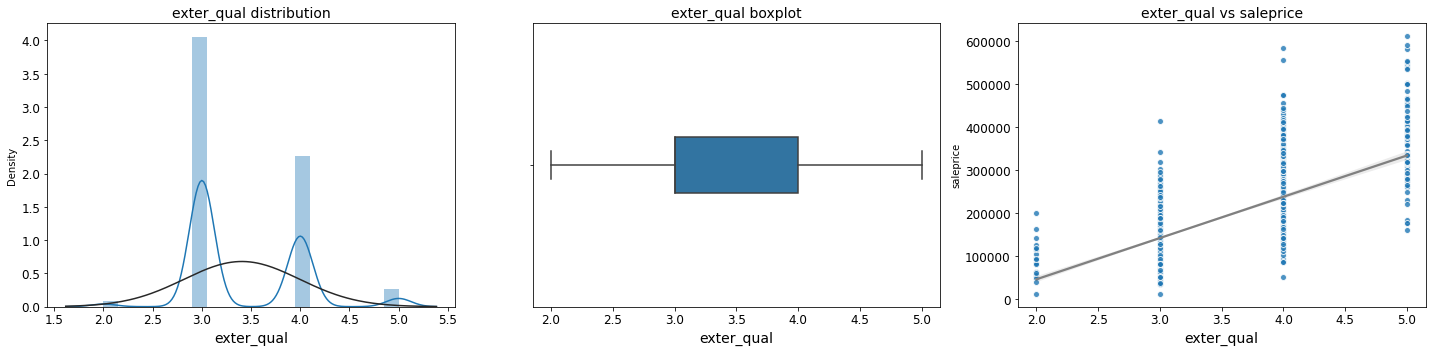

In [17]:
numeric_col_plots(train, ['exter_qual'])

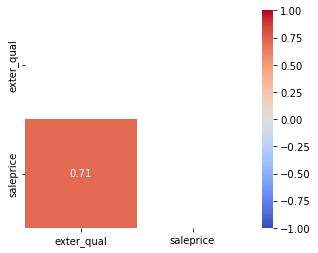

In [18]:
heatmap(train, ['exter_qual', 'saleprice'])

#### `bsmt_qual` and `bsmt_cond`

In [19]:
to_ordinal_numeric(train, 'bsmt_qual', quality_dict)
to_ordinal_numeric(train, 'bsmt_cond', quality_dict)

In [20]:
train['bsmt_qual'] = train['bsmt_qual'].fillna(0)
train['bsmt_cond'] = train['bsmt_cond'].fillna(0)

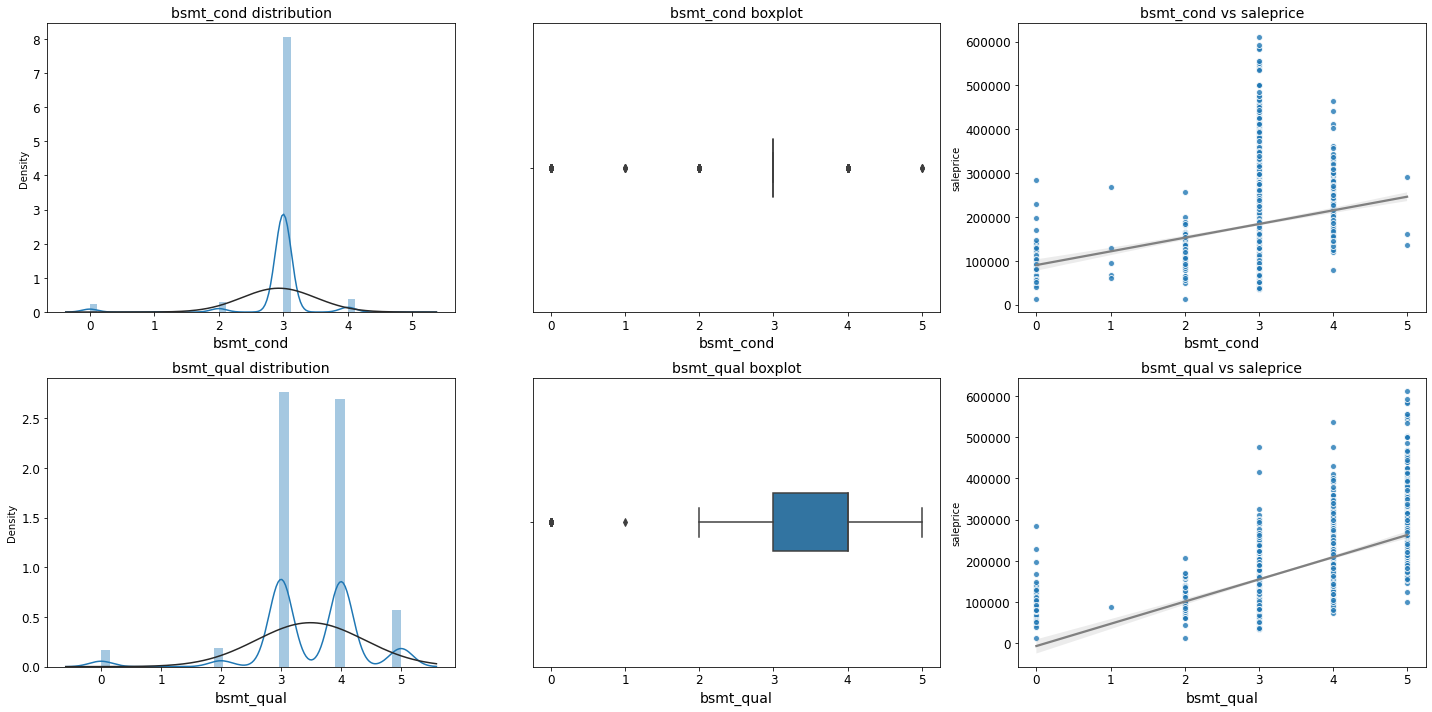

In [21]:
numeric_col_plots(train, ['bsmt_qual', 'bsmt_cond'])

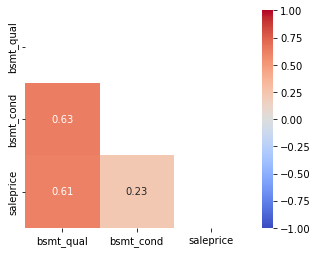

In [22]:
heatmap(train, ['bsmt_qual', 'bsmt_cond', 'saleprice'])

Seems like `bsmt_cond` is collinear with `bsmt_qual`, so we have to exclude it from our model.

In [23]:
drop_col(train, ['bsmt_cond'])

#### `bsmt_exposure`

In [24]:
bsmt_exposure_dict = {'Gd': 4,
                      'Av': 3,
                      'Mn': 2,
                      'No': 1,
                      'NA': 0}

to_ordinal_numeric(train, 'bsmt_exposure', bsmt_exposure_dict)
train['bsmt_exposure'] = train['bsmt_exposure'].fillna(0)

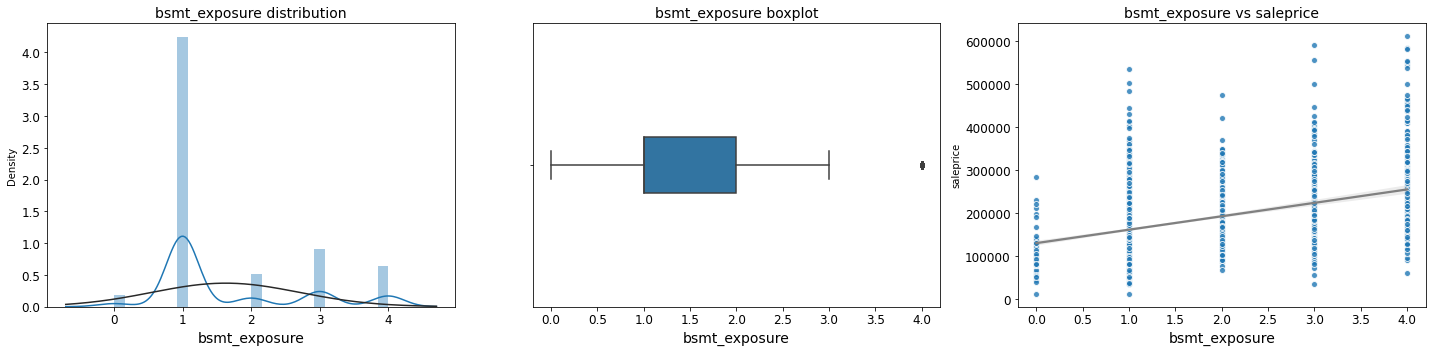

In [25]:
numeric_col_plots(train, ['bsmt_exposure'])

#### `bsmtfin_type_1` and `bsmtfin_type_2`

In [26]:
train['bsmtfin_type_1'].value_counts()

GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: bsmtfin_type_1, dtype: int64

In [27]:
bsmtfin_dict = {'GLQ': 6,
                'ALQ': 5,
                'BLQ': 4,
                'Rec': 3,
                'LwQ': 2,
                'Unf': 1,
                'NA': 0}

to_ordinal_numeric(train, 'bsmtfin_type_1', bsmtfin_dict)
train['bsmtfin_type_1'] = train['bsmtfin_type_1'].fillna(0)

to_ordinal_numeric(train, 'bsmtfin_type_2', bsmtfin_dict)
train['bsmtfin_type_2'] = train['bsmtfin_type_2'].fillna(0)

In [28]:
train['bsmtfin_type_2'].value_counts()

1.0    1749
3.0      80
2.0      60
0.0      56
4.0      48
5.0      35
6.0      23
Name: bsmtfin_type_2, dtype: int64

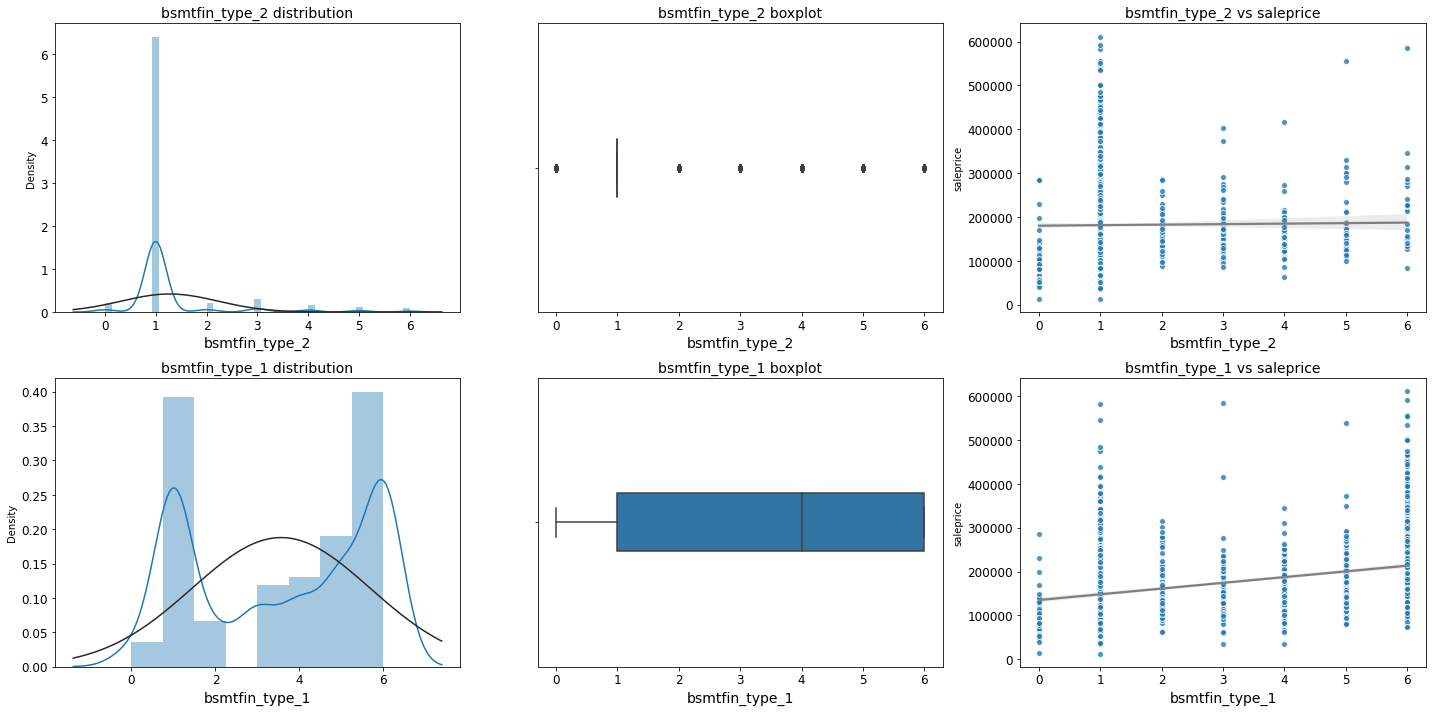

In [29]:
numeric_col_plots(train, ['bsmtfin_type_1', 'bsmtfin_type_2'])

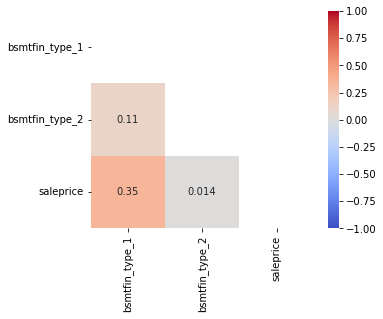

In [30]:
heatmap(train, ['bsmtfin_type_1', 'bsmtfin_type_2', 'saleprice'])

Majority of the values in `bsmtfin_type_2` are rated as 'Unfinished'. This feature is not collinear with `bsmtfin_type_1`, but with such little correlation with sale price, we can exclude it from our model.

In [31]:
drop_col(train, ['bsmtfin_type_2'])

#### `heating_qc`

In [32]:
to_ordinal_numeric(train, 'heating_qc', quality_dict)

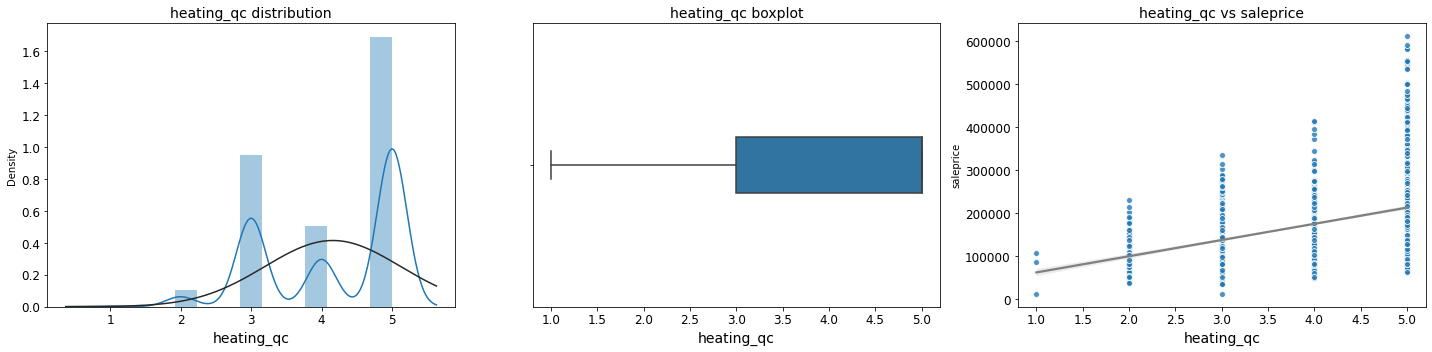

In [33]:
numeric_col_plots(train, ['heating_qc'])

#### `electrical`

In [34]:
elect_dict = {'SBrkr': 4,
              'FuseA': 3,
              'FuseF': 2,
              'FuseP': 1,
              'Mix': 0}

to_ordinal_numeric(train, 'electrical', elect_dict)

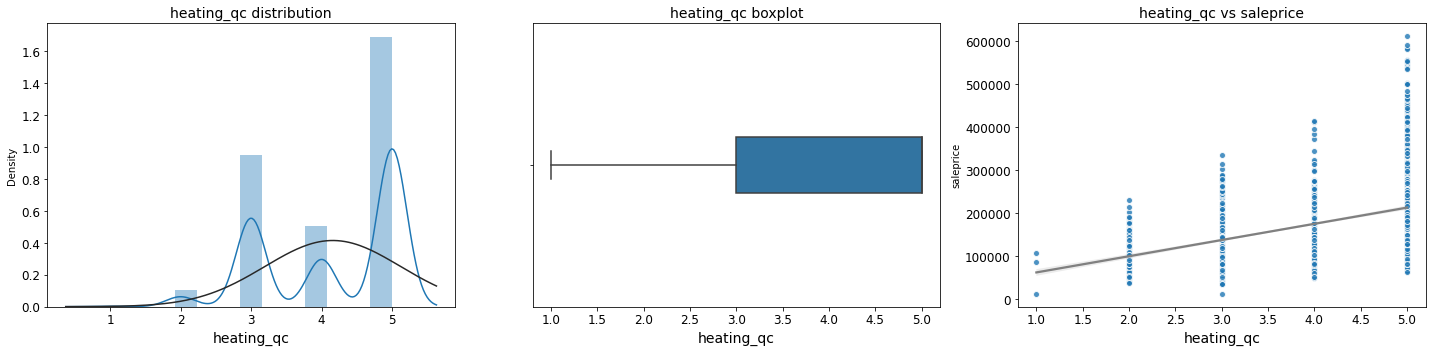

In [35]:
numeric_col_plots(train, ['electrical'])

#### `kitchen_qual`

In [36]:
to_ordinal_numeric(train, 'kitchen_qual', quality_dict)

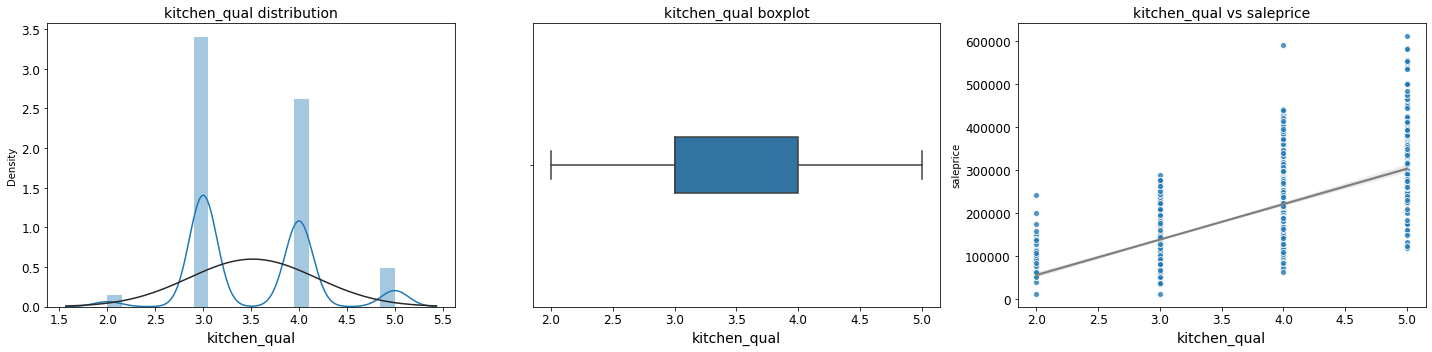

In [37]:
numeric_col_plots(train, ['kitchen_qual'])

#### `functional`

In [38]:
functional_dict = {'Typ': 7,
                   'Min1': 6,
                   'Min2': 5,
                   'Mod': 4,
                   'Maj1': 3,
                   'Maj2': 2,
                   'Sev': 1,
                   'Sal': 0}

to_ordinal_numeric(train, 'functional', functional_dict)

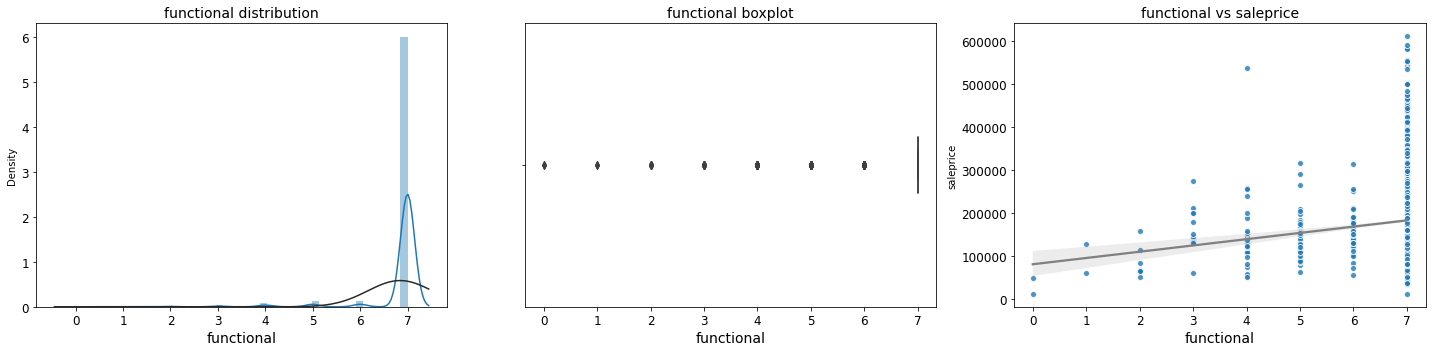

In [39]:
numeric_col_plots(train, ['functional'])

#### `fireplace_qu`

In [40]:
to_ordinal_numeric(train, 'fireplace_qu', quality_dict)
train['fireplace_qu'] = train['fireplace_qu'].fillna(0)

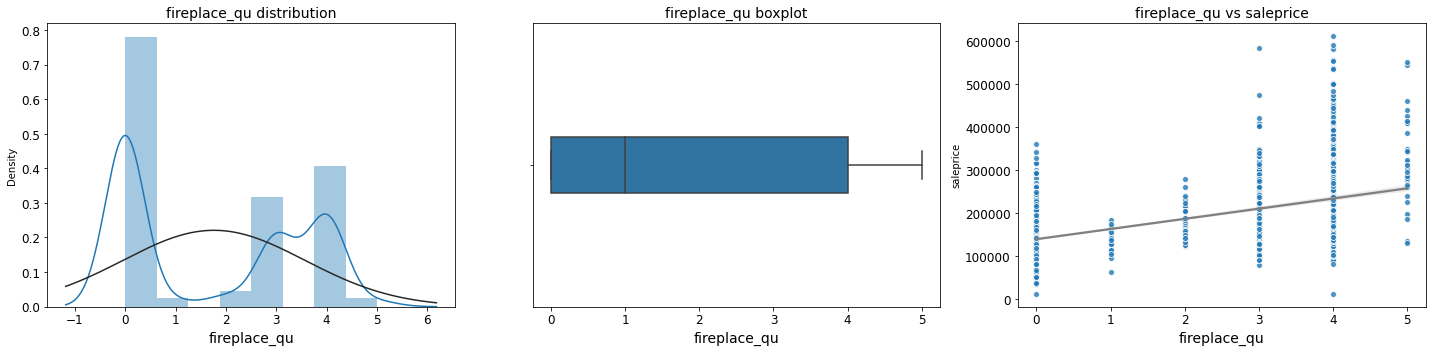

In [41]:
numeric_col_plots(train, ['fireplace_qu'])

#### `garage_finish`

In [42]:
garage_fin_dict = {'Fin': 3,
                   'RFn': 2,
                   'Unf': 1,
                   'None': 0}

to_ordinal_numeric(train, 'garage_finish', garage_fin_dict)
train['garage_finish'] = train['garage_finish'].fillna(0)

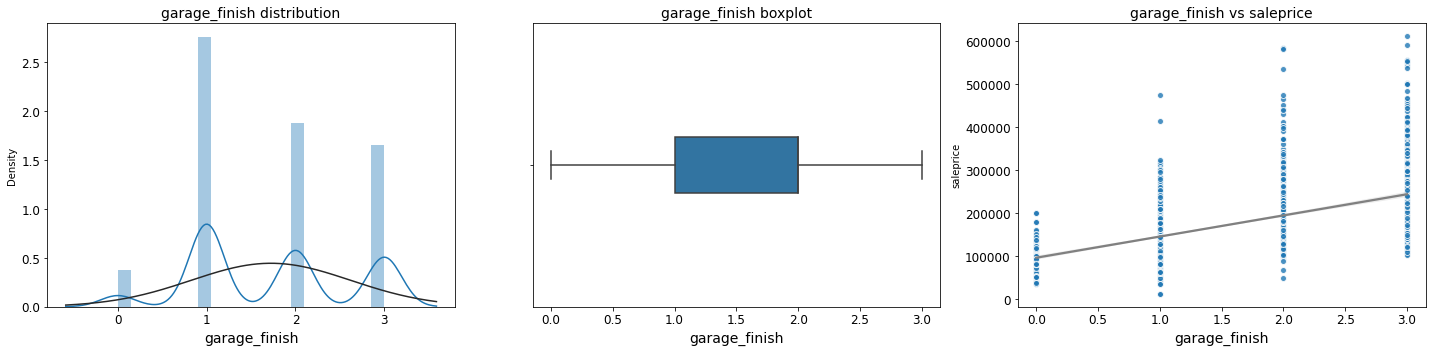

In [43]:
numeric_col_plots(train, ['garage_finish'])

#### `garage_qual`

In [44]:
to_ordinal_numeric(train, 'garage_qual', quality_dict)
train['garage_qual'] = train['garage_qual'].fillna(0)

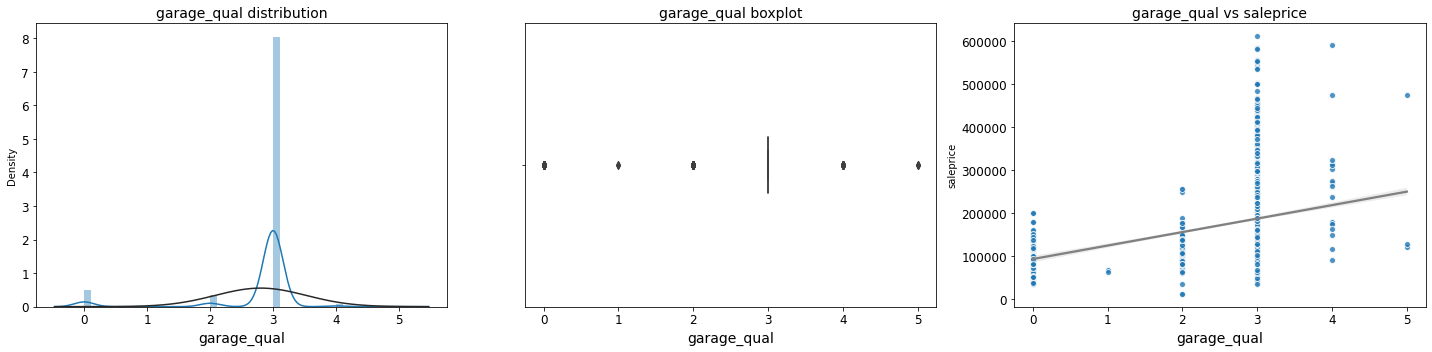

In [45]:
numeric_col_plots(train, ['garage_qual'])

#### `paved_drive`

In [46]:
paved_drive_dict = {'Y': 2,
                    'P': 1,
                    'N': 0}

to_ordinal_numeric(train, 'paved_drive', paved_drive_dict)

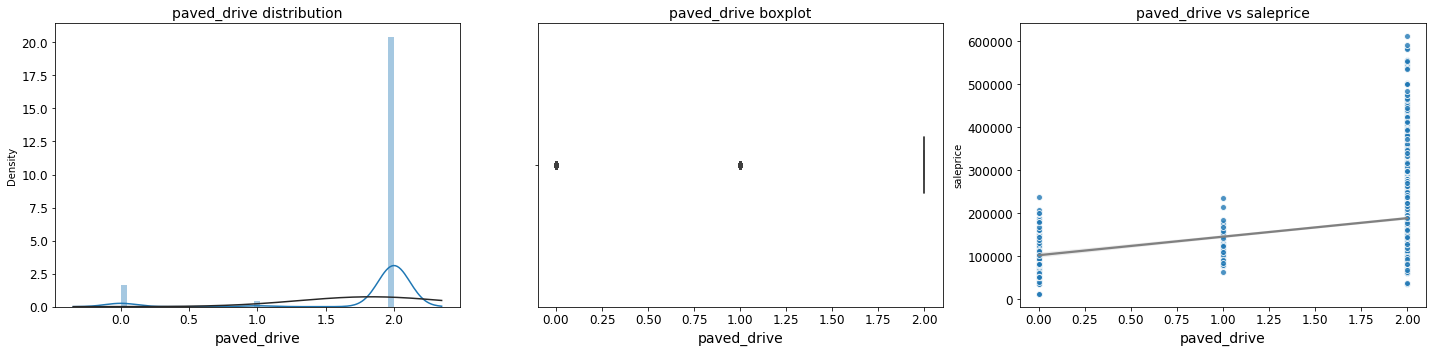

In [47]:
numeric_col_plots(train, ['paved_drive'])

#### `fence`

In [48]:
fence_dict = {'GdPrv': 4,
              'MnPrv': 3,
              'GdWo': 2,
              'MnWw': 1,
              'None': 0}

to_ordinal_numeric(train, 'fence', fence_dict)
train['fence'] = train['fence'].fillna(0)

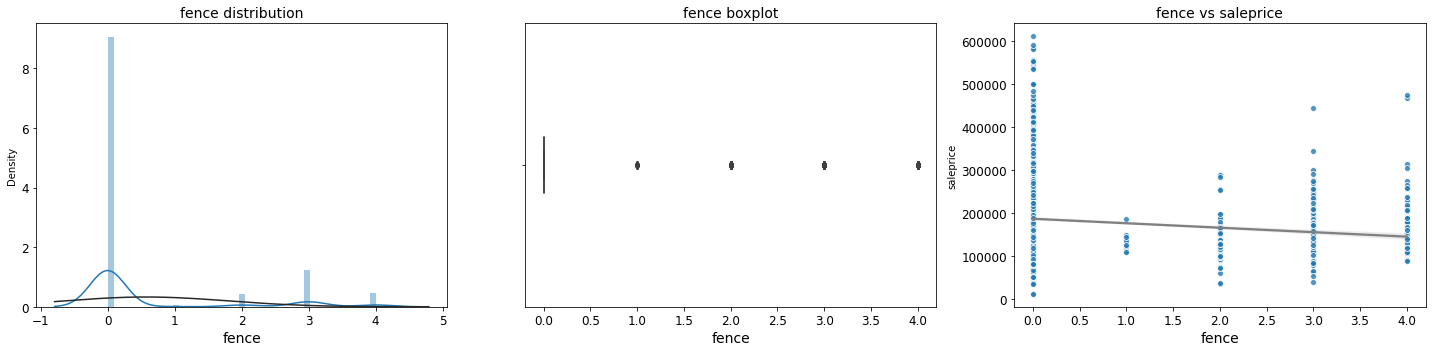

In [49]:
numeric_col_plots(train, ['fence'])

Fence quality has a negative correlation with sale price, but from the plots above, we can see it is mainly due to the majority of houses not having any fences, and these houses together made up a higher median price than houses with fences. This feature is thus a poor variable to include in our model as it gives an inaccurate correlation of fences and sale price.

In [50]:
drop_col(train, ['fence'])

### Dropping outliers and filling in null values with 0 or 'None' for the rest of the columns

In [51]:
# function for filling null values with 'None'
def fill_null_w_none(df, obj_cols):
    for col in obj_cols:
        df[col] = df[col].fillna('None')

In [52]:
# function for filling null values with 0
def fill_null_w_zero(df, num_cols):
    for col in num_cols:
        df[col] = df[col].fillna(0)

In [53]:
fill_null_w_none(train, ['mas_vnr_type', 'garage_type'])
    
fill_null_w_zero(train, ['mas_vnr_area', 'garage_area', 'total_bsmt_sf', 'bsmt_full_bath'])

In [54]:
# dropping outliers
train.drop(train[train['lot_frontage'] > 300].index, inplace = True)
train.drop(train[train['lot_area'] > 100_000].index, inplace = True)
train.drop(train[train['total_bsmt_sf'] > 4_000].index, inplace = True)
train.drop(train[train['gr_liv_area'] > 4_500].index, inplace = True)
train.drop(train[train['wood_deck_sf'] > 1_000].index, inplace = True)
train.drop(train[train['mas_vnr_area'] > 1_200].index, inplace = True)
train.reset_index(drop=True, inplace=True)

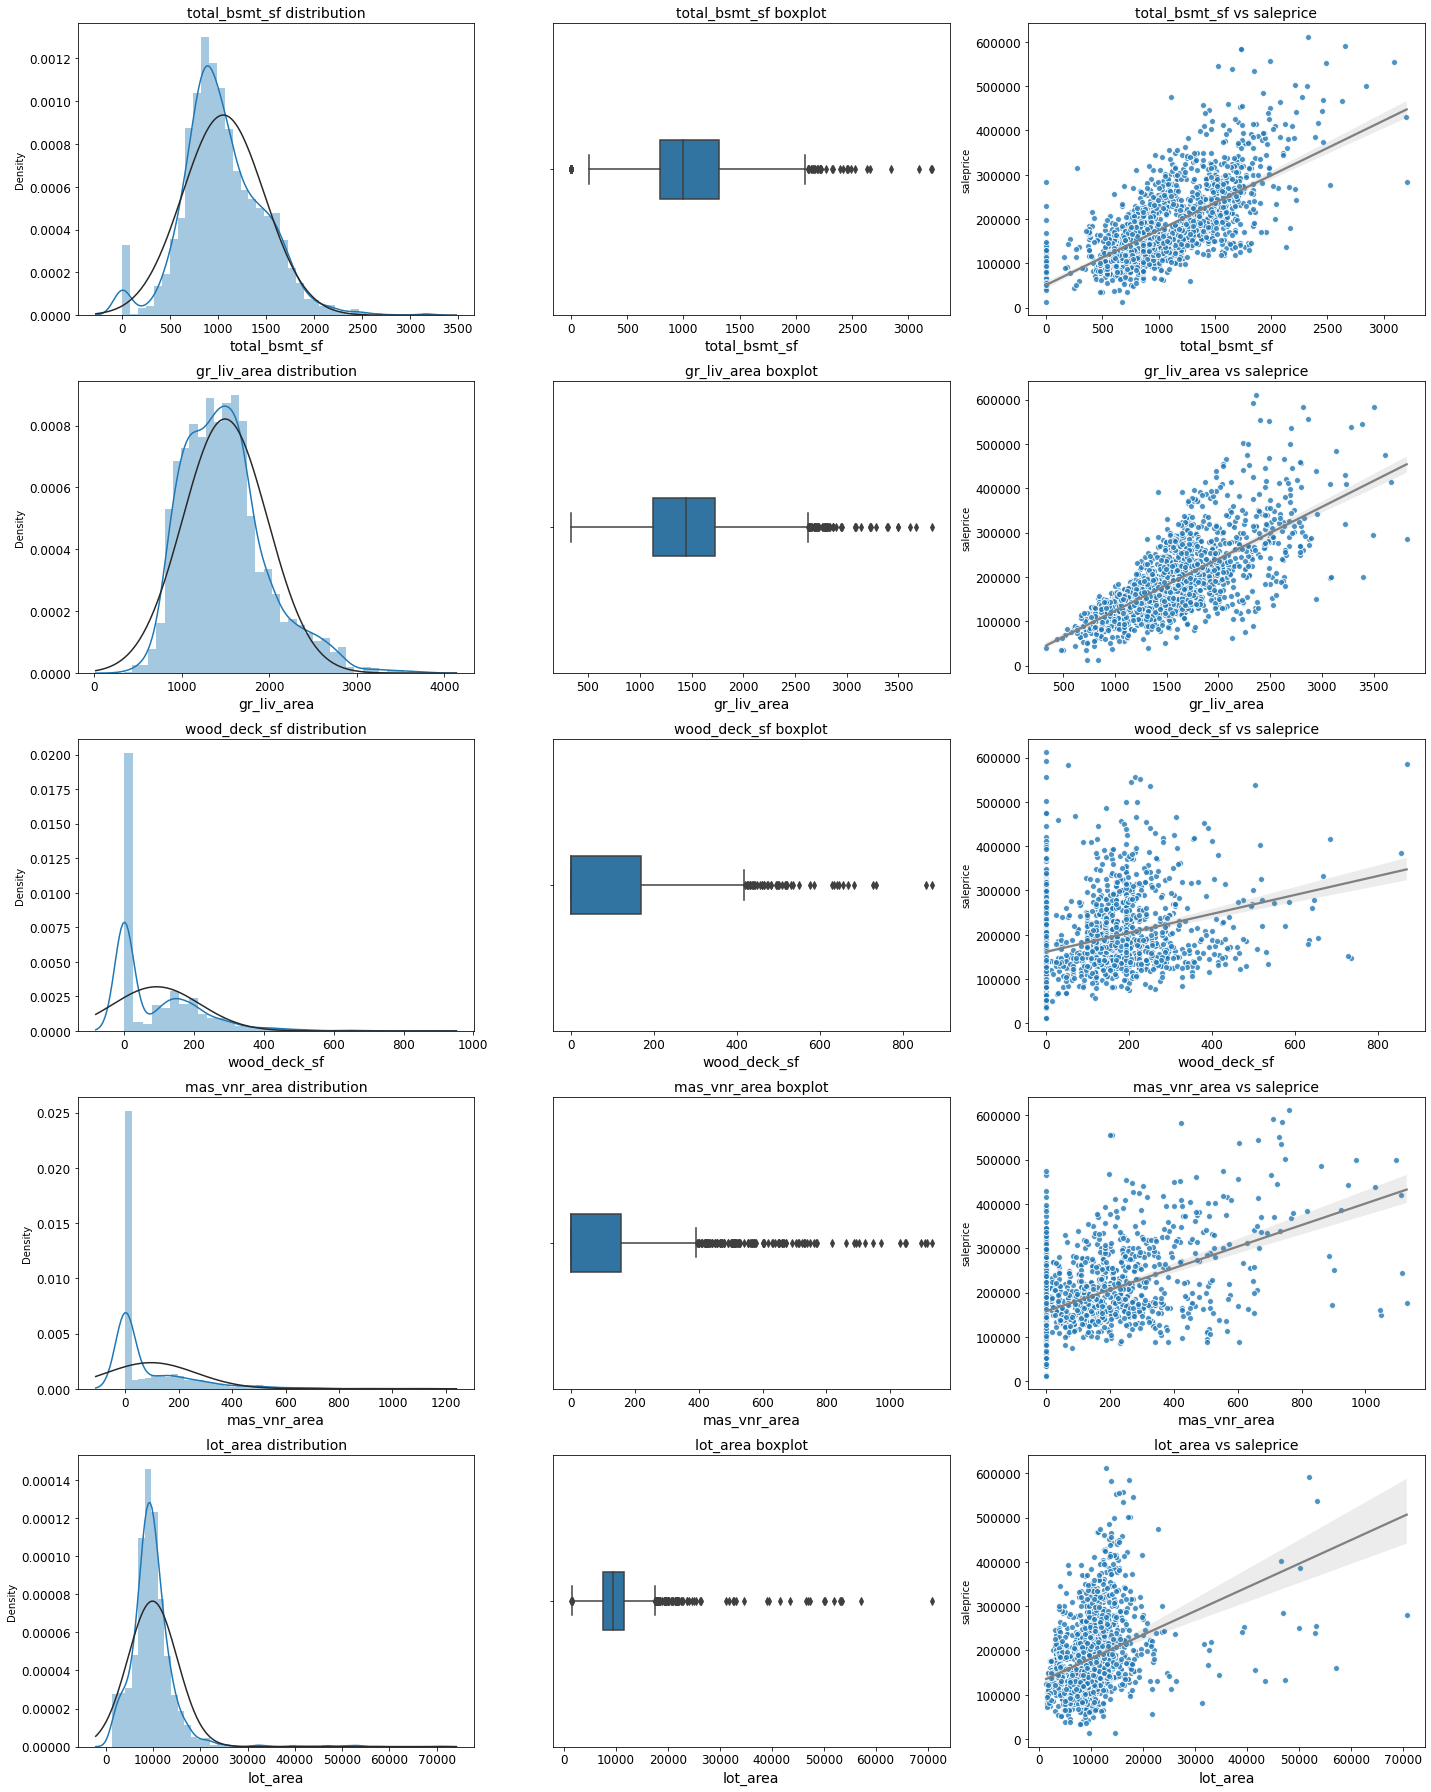

In [55]:
# checking scatter plots again after dropping outliers
numeric_col_plots(train, ['lot_area', 'total_bsmt_sf', 'gr_liv_area',
                          'wood_deck_sf', 'mas_vnr_area'])

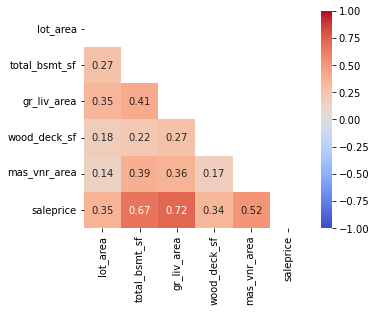

In [56]:
# checking correlation with sale price again
heatmap(train, ['lot_area', 'total_bsmt_sf', 'gr_liv_area',
                'wood_deck_sf', 'mas_vnr_area', 'saleprice'])

Generally, every feature has slight increased correlation with sale price after removing the outliers. Not too much, which is good.

## Feature Engineering and Further Analysis

### `exterior_1st` and `exterior_2nd`

We suspect there might be houses with only a single exterior material, thus both `exterior_1st` and `exterior_2nd` might have the same values. This might multiply the effect which may affect the accuracy of the model if we include both columns. We need to investigate if this is true.

In [57]:
# creating a new column to check exterior_1st and exterior_2nd values against each other
for index, val in enumerate(train['exterior_1st']):
    if val != train.loc[index, 'exterior_2nd']:
        train.loc[index, 'exterior'] = val + " / " + train.loc[index, 'exterior_2nd']
    else:
        train.loc[index, 'exterior'] = val

In [58]:
pd.DataFrame(train['exterior'].value_counts()).head(20)

exterior
VinylSd                 711
MetalSd                 321
HdBoard                 259
Wd Sdng                 235
Plywood                 123
CemntBd / CmentBd        88
WdShing / Wd Shng        34
BrkFace                  32
HdBoard / Plywood        26
AsbShng                  25
Stucco                   19
BrkFace / Wd Sdng        15
Plywood / Brk Cmn        14
Wd Sdng / Plywood        13
Wd Sdng / Wd Shng        12
WdShing / Plywood         9
VinylSd / Wd Shng         7
BrkFace / Plywood         6
Plywood / HdBoard         6
AsbShng / Plywood         4

Seems like majority of the houses have a single exterior material (around 90%), and thus their values for both these columns are the same. Some values are the same but were misspelt (e.g. 'CemntBd' and 'CmentBd'). To prevent "double counting" which would cause inaccuracy to our model, we will be dropping `exterior_2nd`.

In [59]:
drop_col(train, ['exterior_2nd', 'exterior'])

### `misc_feature`

Miscellaneous features not covered in other categories. There are 1986 null values (96.8% nulls). The information for this feature is very vague, with very little values. Thus we will convert this column to indicate the presence of miscellaneous features. The values will be {yes: 1}, or {no: 0}. We will then check the correlation to sale price and see if this feature is worth it to include into our model or not. We hope to expect a rise in value if there are miscellaneous features.

In [60]:
misc_feature_dict = {'Shed': 1,
                     'Gar2': 1,
                     'Othr': 1,
                     'TenC': 1}

to_ordinal_numeric(train, 'misc_feature', misc_feature_dict)

In [61]:
fill_null_w_zero(train, ['misc_feature'])

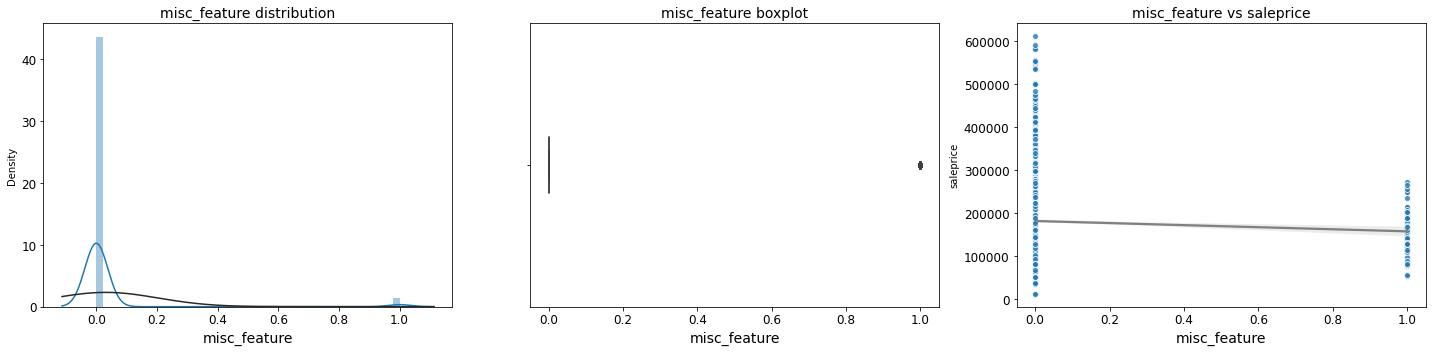

In [62]:
numeric_col_plots(train, ['misc_feature'])

Seems like the number of houses with miscellaneous features are so little that they cannot give enough impact to correlate positively with sale price. Thus, this feature is not useful to our model and we will drop it.

In [63]:
drop_col(train, ['misc_feature'])

### `lot_frontage`

Out of the columns that describe the lot of the property, only `lot_frontage` has missing values. Lot frontage is the width of a lot, measured at the front part or face of the lot, facing the street. There are 330 null values for this column, so we will have to use other lot descriptions (`lot_area`, `lot_shape`, `lot_config`) to estimate appropriate values for them.

As a rough guide, below shows a heatmap showing the correlation of `saleprice`, `lot_frontage` and `lot_area`, before inputing values to all the nulls in `lot_frontage` column. We will be using Iterative Imputer from sklearn, using linear regression as an estimator method.

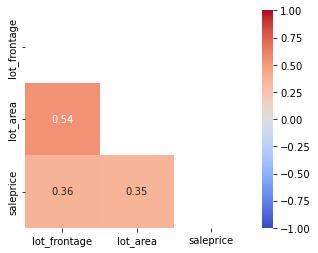

In [64]:
heatmap(train, ['lot_frontage','lot_area','saleprice'])

Below scatter plots show that the lot description columns are correlated and that it is sensible to use them for linear regression to estimate the values for input into the nulls.

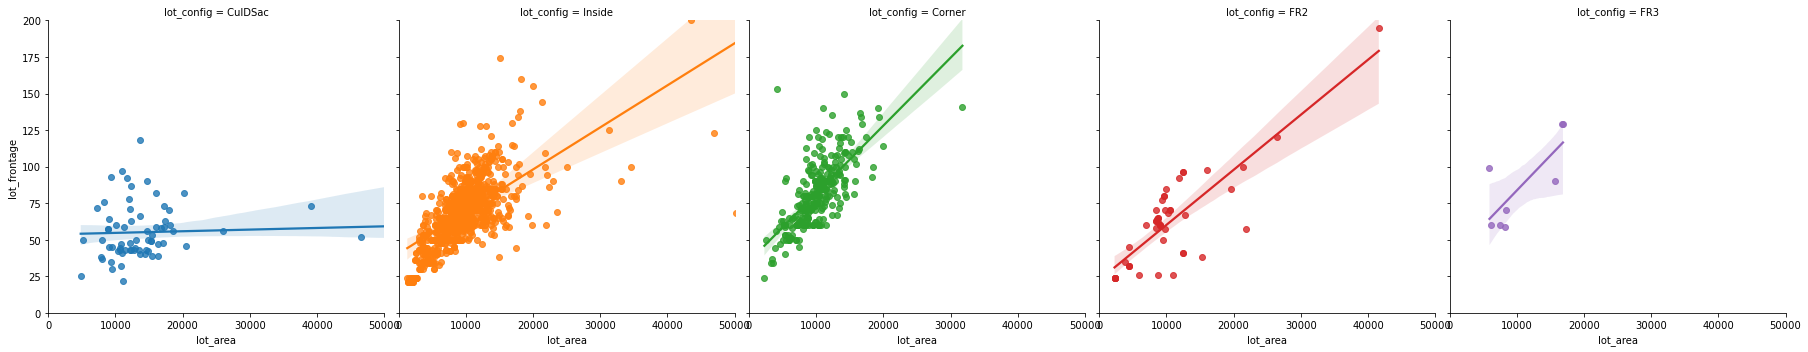

In [65]:
g = sns.lmplot(x = 'lot_area', y = 'lot_frontage', col = 'lot_config', 
               hue = 'lot_config', data = train)
g.set(xlim = (0, 50_000), ylim = (-.05, 200));

Dummies for `lot_shape` and `lot_config` will be created to input missing `lot_frontage` values.

In [66]:
lotdf = train[['lot_frontage','lot_area','lot_shape','lot_config']].copy(deep=True)
lotdf = pd.get_dummies(data=lotdf, columns=['lot_shape','lot_config'], drop_first=True)

In [67]:
# using Iterative Imputer with Linear Regression as the estimator
it_imp = IterativeImputer(estimator = LinearRegression())

it_imp_lotdf = it_imp.fit_transform(lotdf)

it_imp_lotdf = pd.DataFrame(it_imp_lotdf)

In [68]:
# replacing the initially null values
train['lot_frontage'] = it_imp_lotdf.loc[:,0]

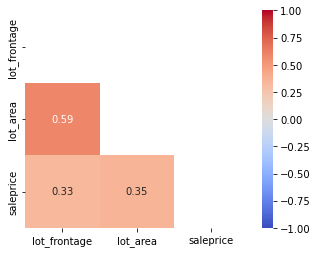

In [69]:
heatmap(train,['lot_frontage','lot_area','saleprice']);

Slight increase in correlation between `lot_area` and `lot_frontage`, which is to be expected, with 330 extra new values. Very slight decrease in correlation observed between `saleprice` and `lot_frontage`, about -0.03. This should still be acceptable as our estimated values did not significantly change the correlation between these 2 variables.

### `year_built` and `yr_sold`

`year_built` shows the original construction dates of the houses. The plots for this column shows a trend where the newer the houses, the more expensive it is. With `yr_sold`, we could find out the age of the house when it was sold, make a new column and explore the correlation with sale price. It may give us a better correlation with sale price than `year_built`.

In [70]:
# age_sold = yr_sold - year_built
for index, val in enumerate(train['year_built']):
    train.loc[index, 'age_sold'] = train.loc[index, 'yr_sold'] - val

In [71]:
# check distribution of age sold
pd.DataFrame(train['age_sold'].value_counts()).sort_index()

age_sold
0.0          79
1.0         154
2.0          62
3.0          44
4.0          57
...         ...
127.0         1
128.0         2
129.0         1
135.0         1
136.0         1

[122 rows x 1 columns]

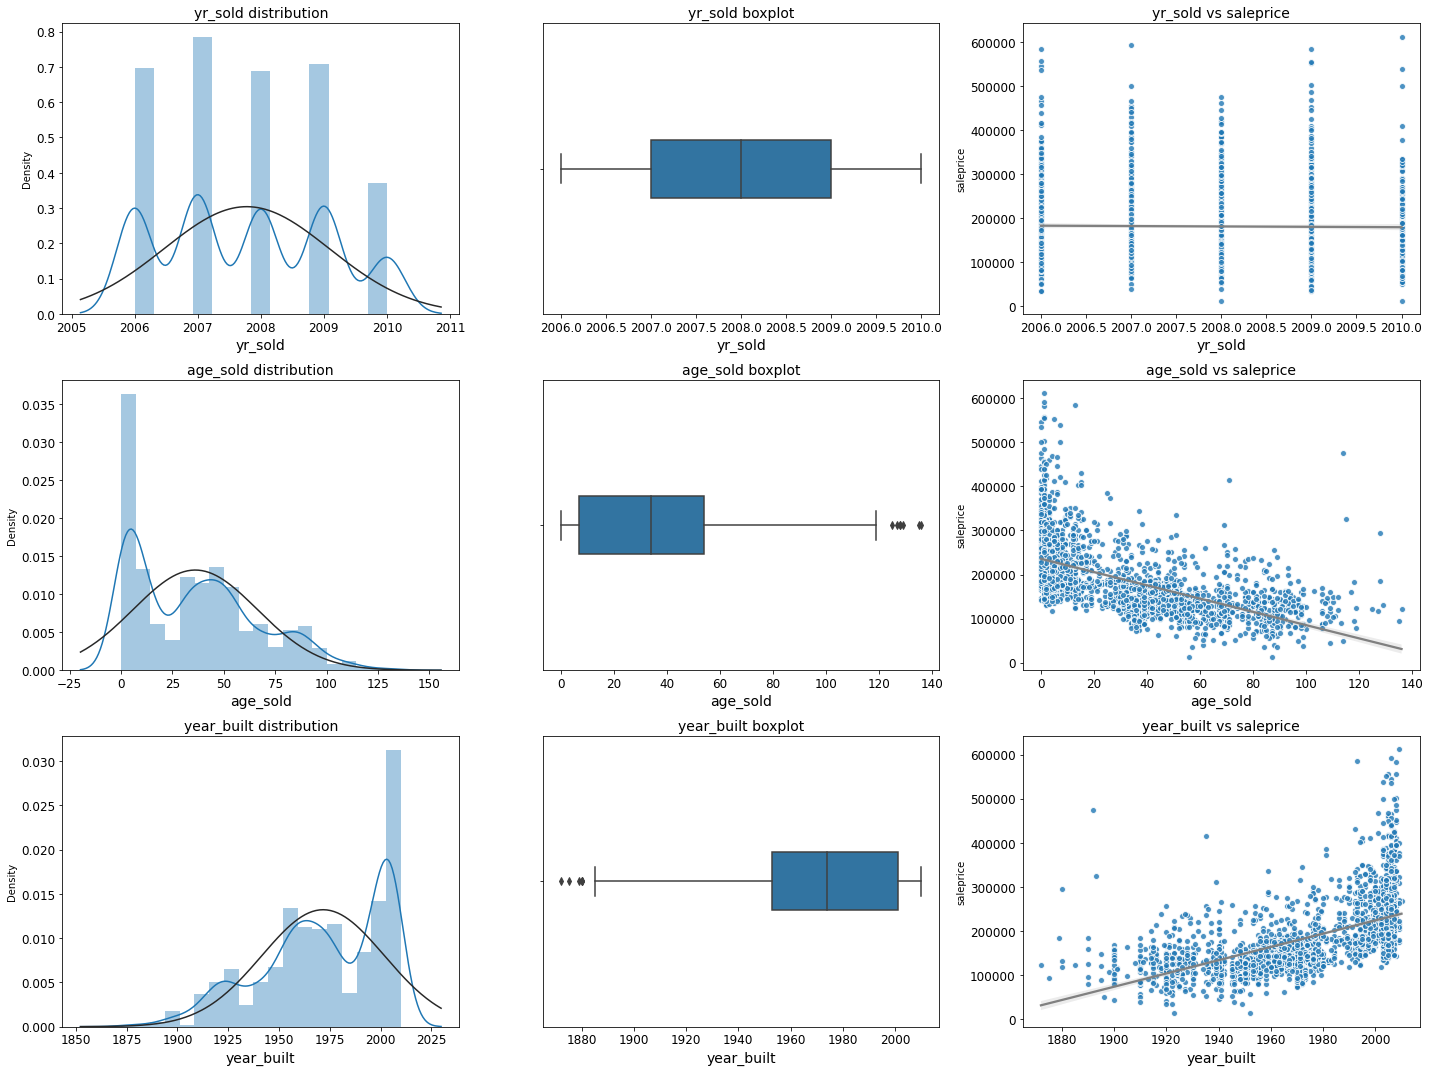

In [72]:
# check the plots
numeric_col_plots(train, ['year_built', 'yr_sold', 'age_sold'])

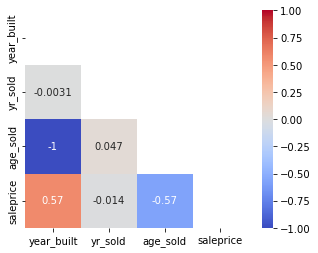

In [73]:
# checking the correlation
heatmap(train, ['year_built', 'yr_sold', 'age_sold', 'saleprice'])

`age_sold` has a strong negative correlation with `log_saleprice`, which makes sense, where the older the house, the lesser it was sold for. `age_sold` and `year_built` are opposite collinear with each other, as this dataset only contains the sales for 5 years. But for a more accurate representation of data, we choose to use `age_sold`, and drop `year_built` and `yr_sold`.

In [74]:
drop_col(train, ['yr_sold'])

### `year_remod/add`

If a house is not remodeled, it might share the same values as `year_built`, thus double counting the values. In order to still retain information for this, we will create a new column that states if the houses were remodeled or not, and explore that correlation with sale price.

In [75]:
# creating a new column to check if year_remod/add and year_built share the same values
# remod done = 1, no remod = 0
for index, val in enumerate(train['year_remod/add']):
    if val != train.loc[index, 'year_built']:
        train.loc[index, 'remod_done'] = 1           # remod done, year values are different
    else:
        train.loc[index, 'remod_done'] = 0           # no remod, year values are same

In [76]:
train['remod_done'].value_counts()

0.0    1099
1.0     945
Name: remod_done, dtype: int64

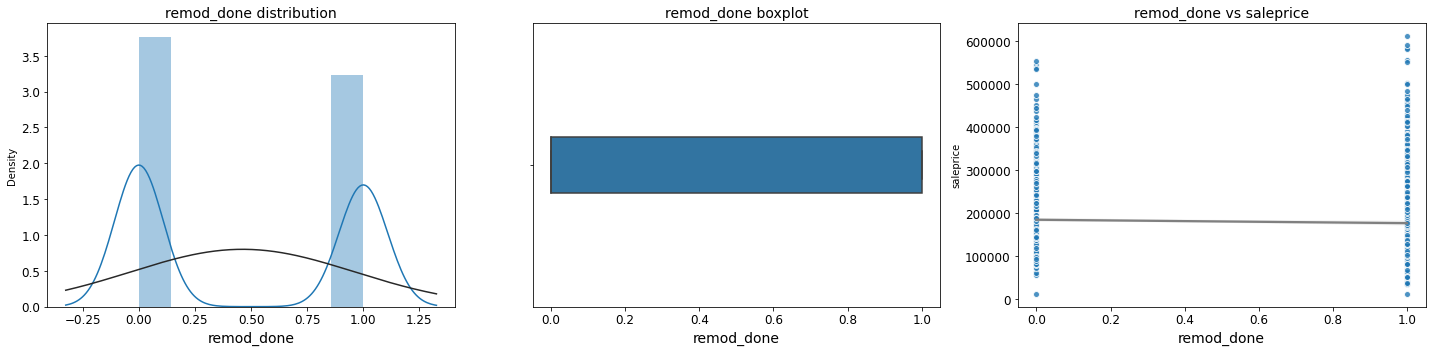

In [77]:
numeric_col_plots(train, ['remod_done'])

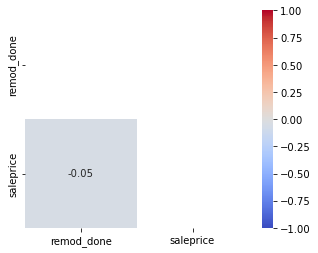

In [78]:
heatmap(train, ['remod_done', 'saleprice'])

About 46% of houses had remodeling done. As suspected, those with no modeling done to their houses have the same year values for both `year_built` and `year_remod/add` columns, making `year_remod/add` a poor variable to include in our model. Even after creating a new column `remod_done`, it is still a poor variable for our model due to poor correlation with sale price. Thus, we will exclude all these columns.

In [79]:
drop_col(train, ['year_built', 'year_remod/add', 'remod_done'])

### `open_porch_sf`, `enclosed_porch`, `3ssn_porch` and `screen_porch`

Many houses in this dataset do not have any of the 4 different porch features. In reality, houses with one or more of these porches should mean increased sale price, however, `enclosed_porch` showed a negative correlation with sale price.

We will be combining the area of all porches into one single feature: `total_porch_area`. We want to see if combining the features would create a greater significance in correlation to sale price.

In [80]:
# combining all porches areas
train['total_porch_area'] = train['open_porch_sf'] + train['enclosed_porch'] + \
                            train['3ssn_porch'] + train['screen_porch']

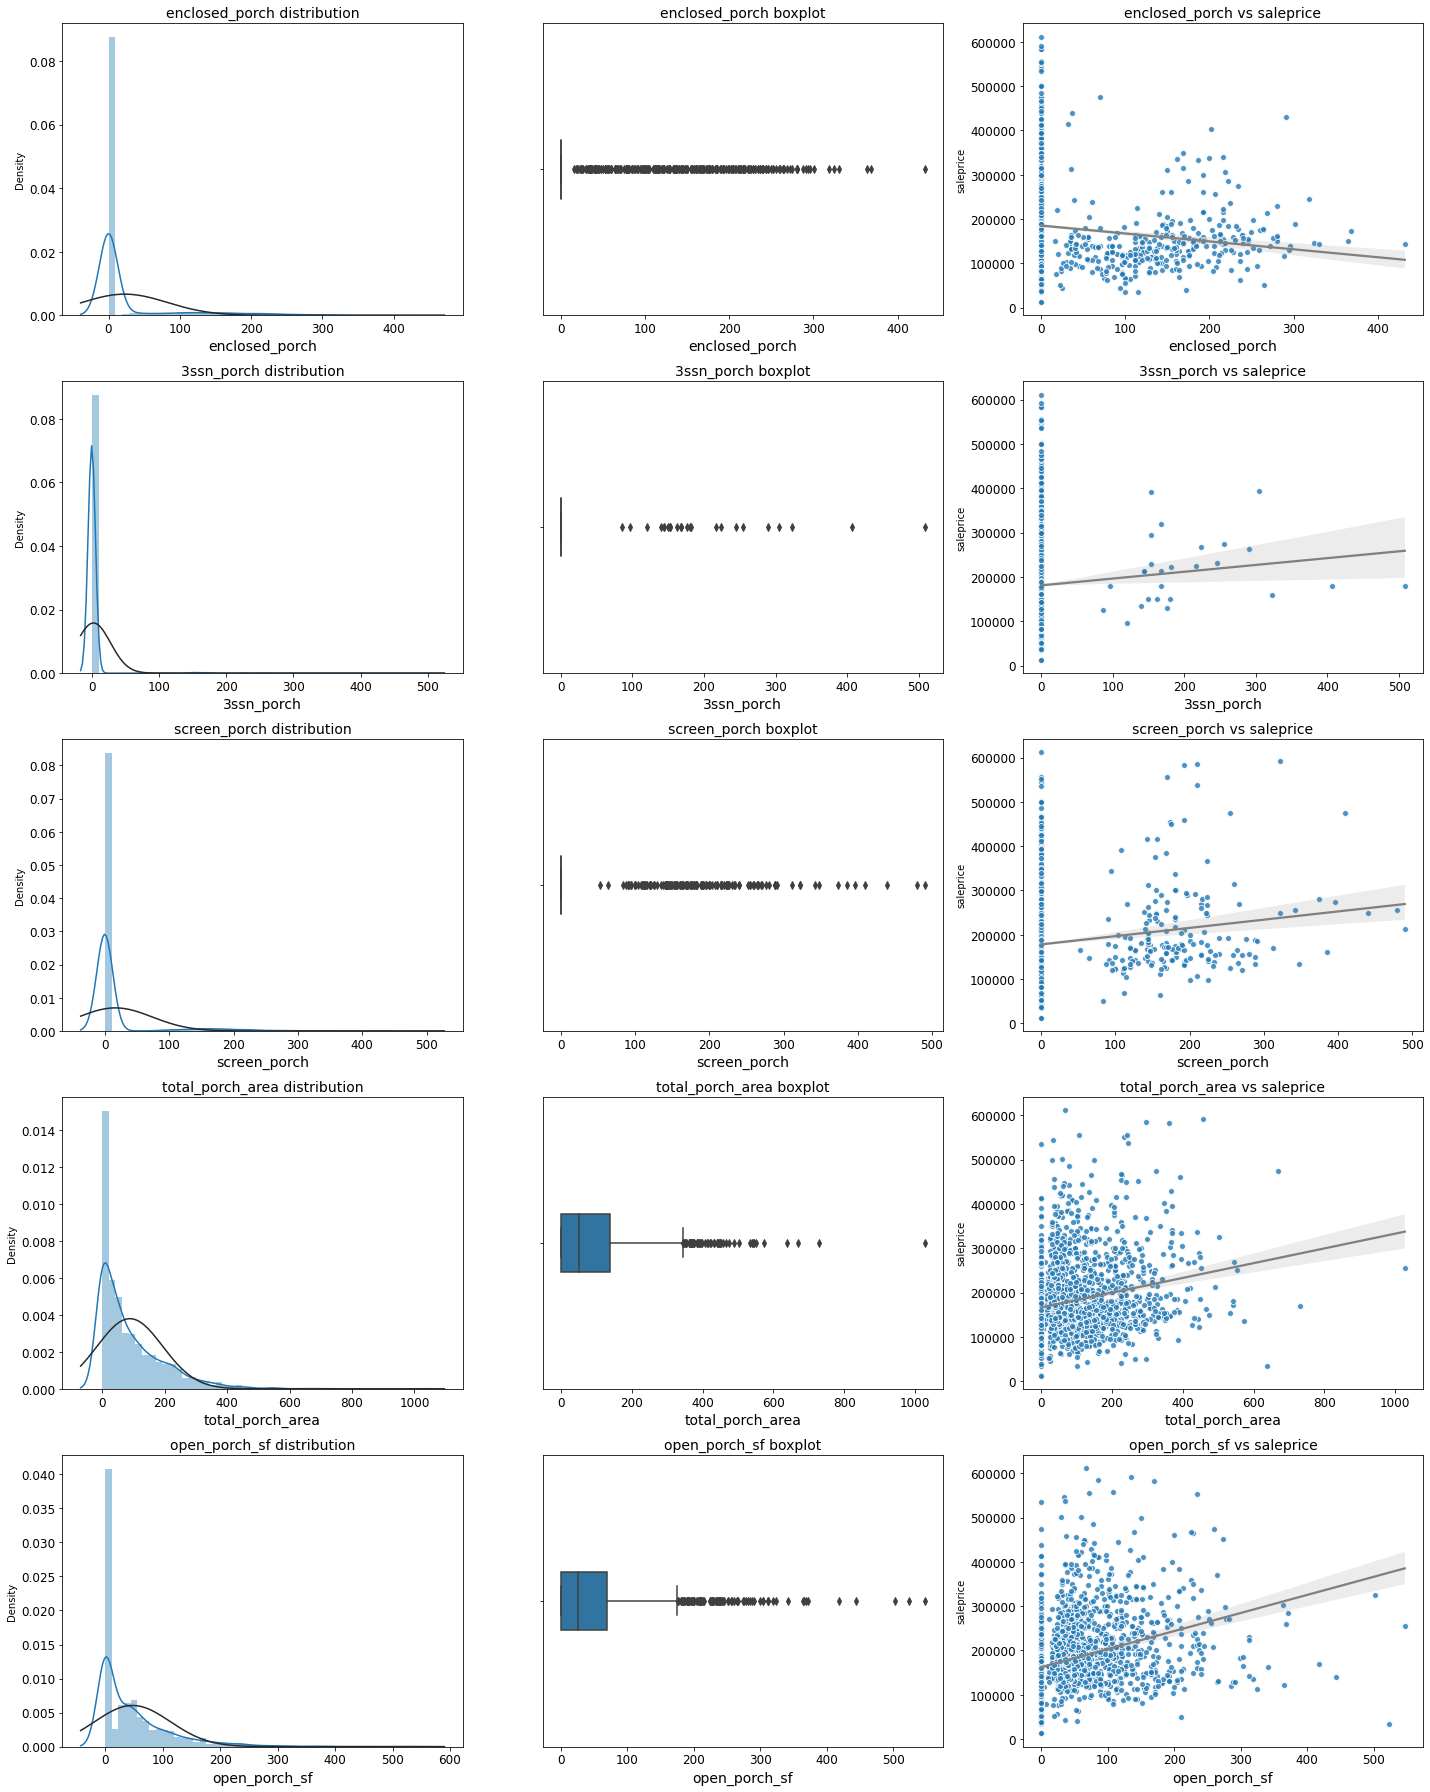

In [81]:
# plotting all porches to compare with total_porch_area
numeric_col_plots(train, ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'total_porch_area'])

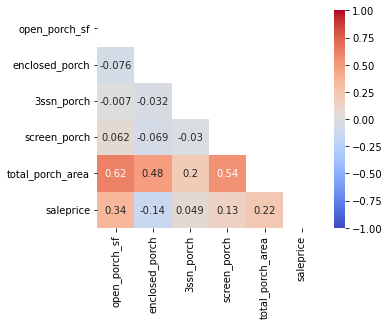

In [82]:
heatmap(train, ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch', 'total_porch_area', 'saleprice'])

`total_porch_area` is positively correlated to sale price, as it should be. We could include it in our model. As a sum of all the area of the porches, we can then drop all other porch features as we want to avoid 'double counting' in our model.

In [83]:
drop_col(train, ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch'])

## Correlation and Plots After Preprocessing

Let us check out the correlation and other plots after preprocessing, if they are prepared enough for the model.

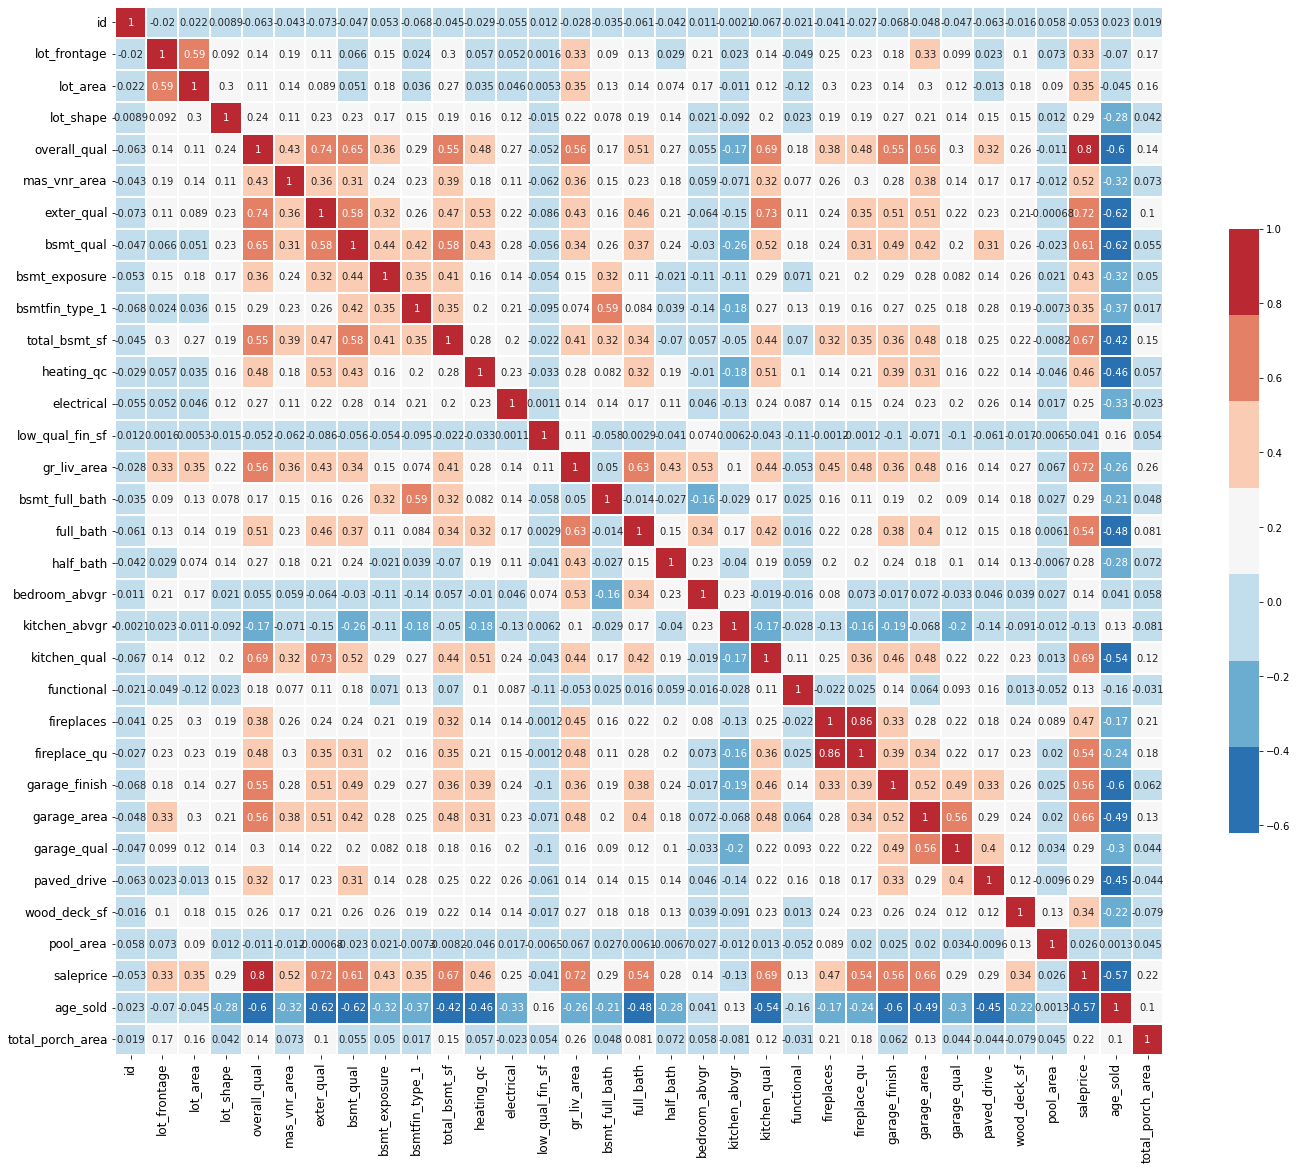

In [84]:
# heatmap to show correlation between numerical features
# most importantly is the correlation of these features with sale price
mask = np.zeros_like(train.corr(), dtype=np.bool)
# mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(train.corr(),
            mask = mask,
            square=True,
            linewidth=0.1,
            cbar_kws = {'shrink':0.5},
            cmap=sns.color_palette("RdBu_r", 7),
            annot = True)
ax.tick_params(labelsize=12)
plt.tight_layout()

In [85]:
# list with only numerical columns
col_numerical = [col for col in train.columns if train[col].dtype != np.object]

# list with only categorical columns
col_categorical = [col for col in train.columns if col not in col_numerical]

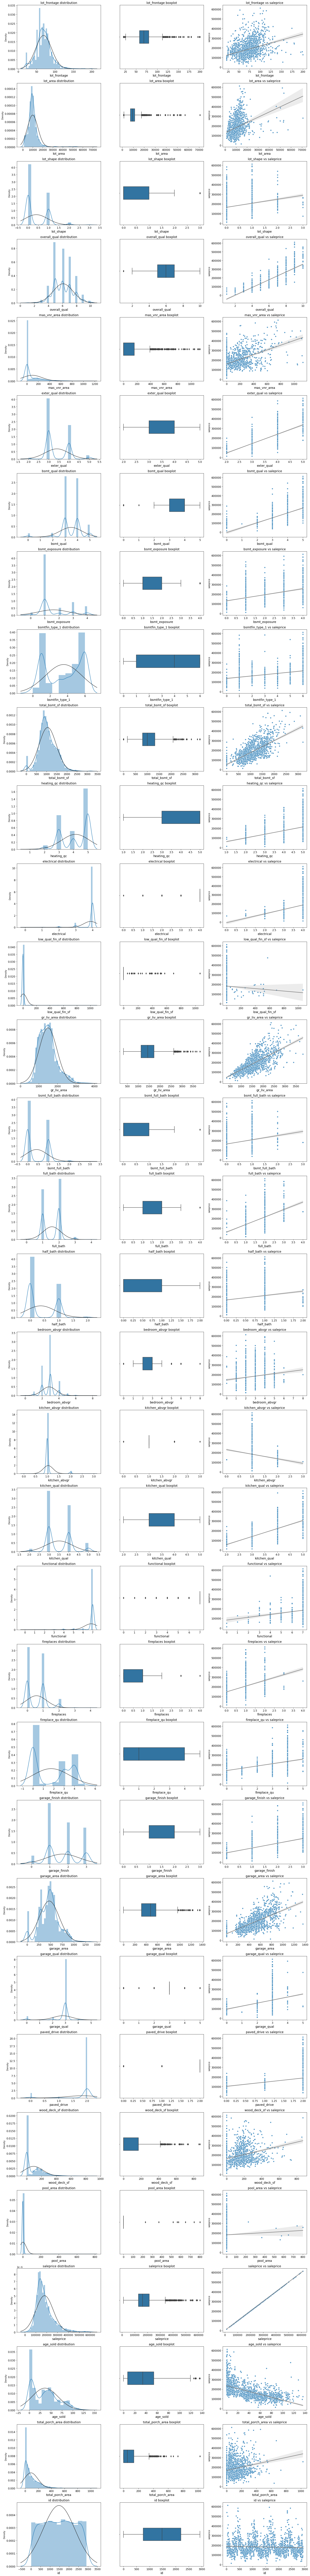

In [86]:
numeric_col_plots(train, col_numerical)

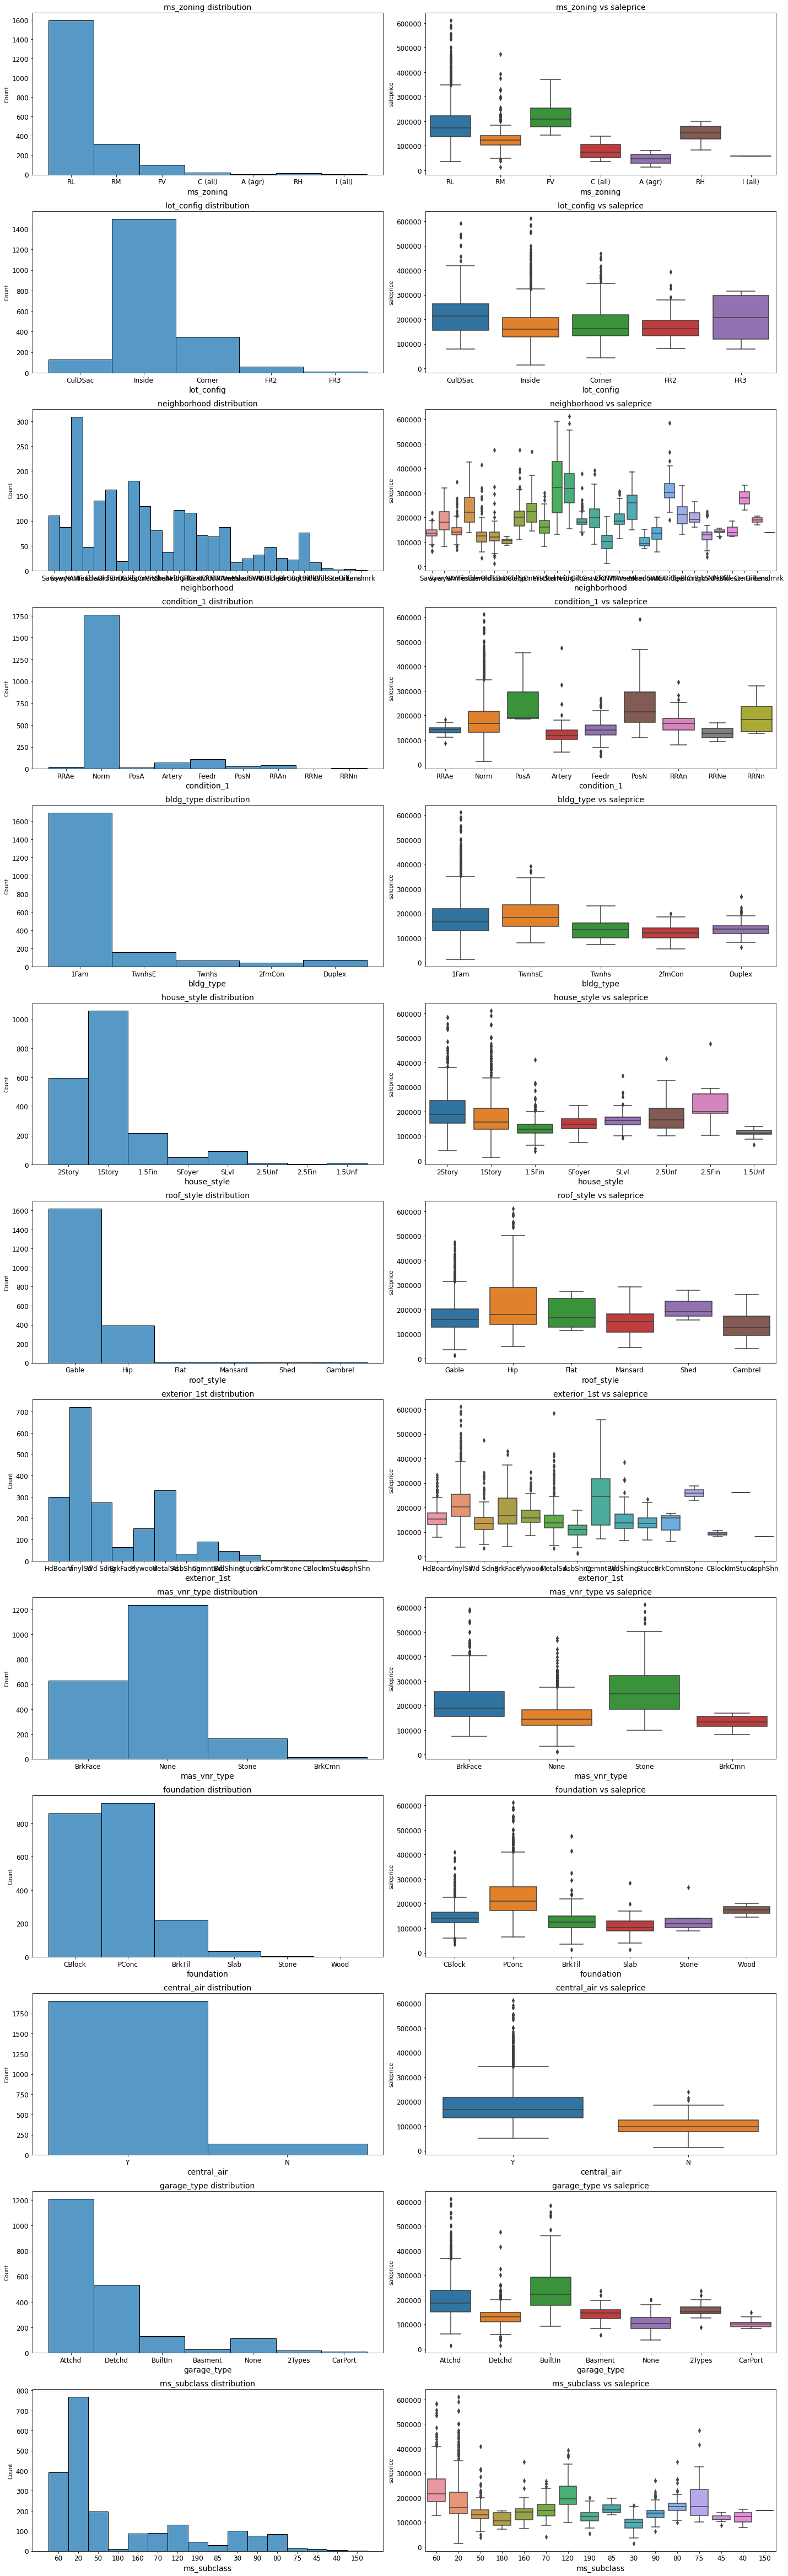

In [87]:
categorical_col_plots(train, col_categorical)

Let us check out the numerical features' correlation to sale price from highest correlation to lowest.

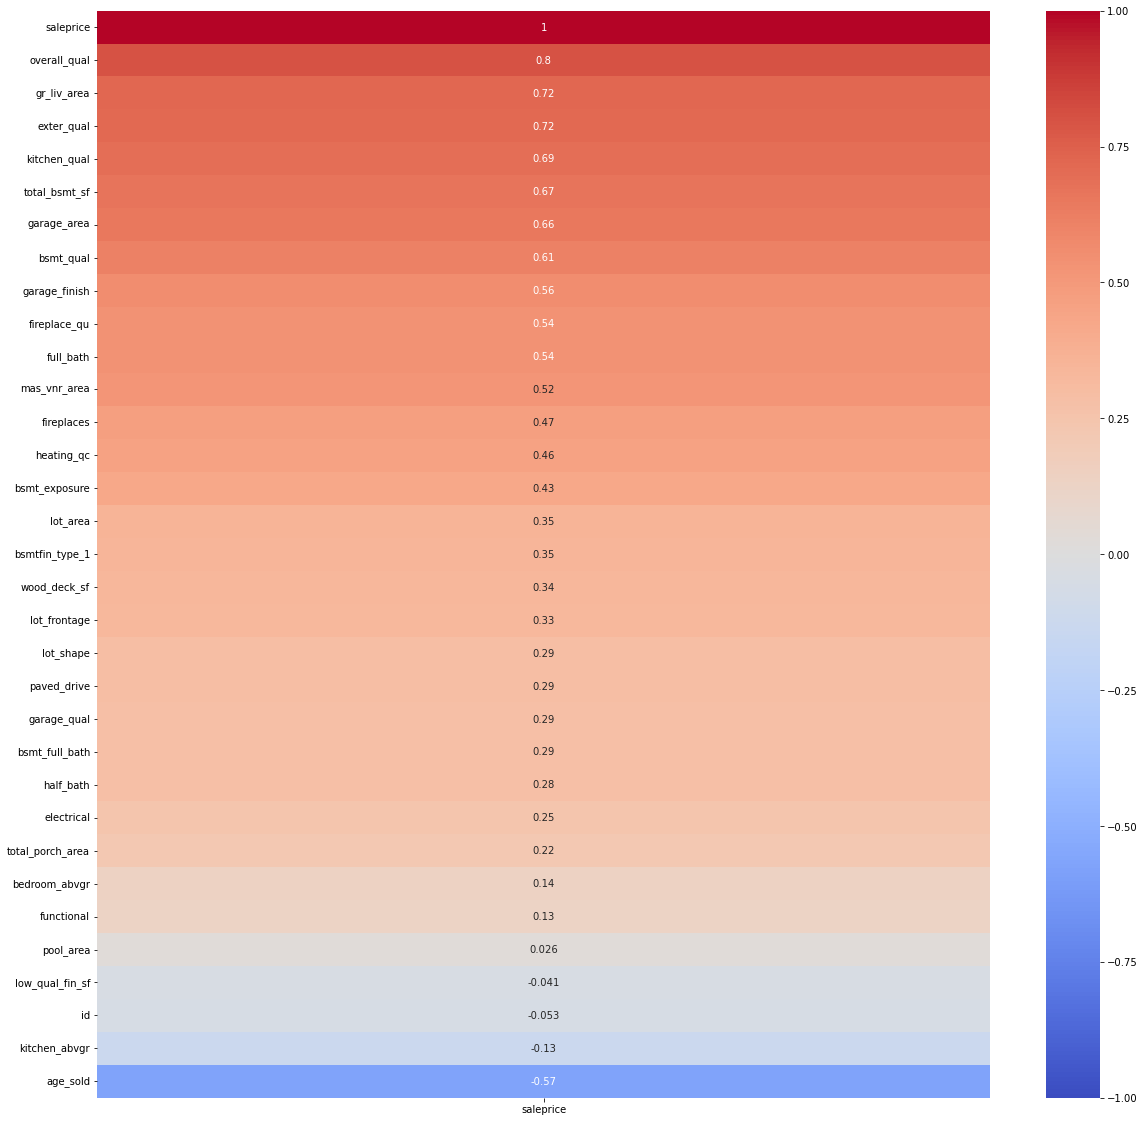

In [88]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr()[['saleprice']].sort_values('saleprice', ascending = False), 
            annot=True, cmap='coolwarm', 
            vmin=-1, vmax=1);

## Applying preprocessing to test dataset

In [89]:
# importing test dataset
test = pd.read_csv('../datasets/test.csv')

In [ ]:
def preprocess_test(df):
    
    # make columns lowercase and replacing spaces with underscores
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    
    # dropping columns
    def drop_col(df, cols_to_drop):
        df.drop(cols_to_drop, axis = 1, inplace = True)
        
    to_drop = ['pid', 'street', 'alley', 'land_contour', 'utilities', 'land_slope',
               'condition_2', 'overall_cond', 'roof_matl', 'exter_cond',
               'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'heating', '1st_flr_sf',
               '2nd_flr_sf', 'bsmt_half_bath', 'totrms_abvgrd','garage_yr_blt',
               'garage_cars', 'garage_cond', 'pool_qc', 'misc_val', 'mo_sold', 'sale_type',
               'bsmt_cond', 'bsmtfin_type_2', 'fence', 'exterior_2nd', 'misc_feature']
    
    drop_col(df, to_drop)
    
    # converting numerical to categorical
    def convert_to_categorical(df, cols_to_convert):
        for i in cols_to_convert:
            df[i] = df[i].astype(str)
            
    to_cat = ['ms_subclass']
    convert_to_categorical(df, to_cat)
    
    # converting ordinal categorical to ordinal numeric
    def to_ordinal_numeric(df, colname, dictionary):
        df[colname] = df[colname].map(dictionary)
        
    lot_shape_dict = {'Reg': 0,
                      'IR1': 1,
                      'IR2': 2,
                      'IR3': 3}
    
    quality_dict = {'Ex': 5,
                    'Gd': 4,
                    'TA': 3,
                    'Fa': 2,
                    'Po': 1,
                    'None': 0}
    
    bsmt_exposure_dict = {'Gd': 4,
                          'Av': 3,
                          'Mn': 2,
                          'No': 1,
                          'NA': 0}
    
    bsmtfin_dict = {'GLQ': 6,
                    'ALQ': 5,
                    'BLQ': 4,
                    'Rec': 3,
                    'LwQ': 2,
                    'Unf': 1,
                    'NA': 0}
    
    elect_dict = {'SBrkr': 4,
                  'FuseA': 3,
                  'FuseF': 2,
                  'FuseP': 1,
                  'Mix': 0}
    
    functional_dict = {'Typ': 7,
                       'Min1': 6,
                       'Min2': 5,
                       'Mod': 4,
                       'Maj1': 3,
                       'Maj2': 2,
                       'Sev': 1,
                       'Sal': 0}
    
    garage_fin_dict = {'Fin': 3,
                       'RFn': 2,
                       'Unf': 1,
                       'None': 0}
    
    paved_drive_dict = {'Y': 2,
                        'P': 1,
                        'N': 0}
    
    to_ordinal_numeric(df, 'lot_shape', lot_shape_dict)
    to_ordinal_numeric(df, 'exter_qual', quality_dict)
    to_ordinal_numeric(df, 'bsmt_qual', quality_dict)
    to_ordinal_numeric(df, 'bsmt_exposure', bsmt_exposure_dict)
    to_ordinal_numeric(df, 'bsmtfin_type_1', bsmtfin_dict)
    to_ordinal_numeric(df, 'heating_qc', quality_dict)
    to_ordinal_numeric(df, 'electrical', elect_dict)
    to_ordinal_numeric(df, 'kitchen_qual', quality_dict)
    to_ordinal_numeric(df, 'functional', functional_dict)
    to_ordinal_numeric(df, 'fireplace_qu', quality_dict)
    to_ordinal_numeric(df, 'garage_finish', garage_fin_dict)
    to_ordinal_numeric(df, 'garage_qual', quality_dict)
    to_ordinal_numeric(df, 'paved_drive', paved_drive_dict)
    
    # filling null values
#     train['bsmt_qual'] = train['bsmt_qual'].fillna(0)
#     train['bsmt_exposure'] = train['bsmt_exposure'].fillna(0)
#     train['bsmtfin_type_1'] = train['bsmtfin_type_1'].fillna(0)
#     train['fireplace_qu'] = train['fireplace_qu'].fillna(0)
#     train['garage_finish'] = train['garage_finish'].fillna(0)
#     train['garage_qual'] = train['garage_qual'].fillna(0)
    
    # function for filling null values with 'None'
    def fill_null_w_none(df, obj_cols):
        for col in obj_cols:
            df[col] = df[col].fillna('None')
            
    # function for filling null values with 0
    def fill_null_w_zero(df, num_cols):
        for col in num_cols:
            df[col] = df[col].fillna(0)
            
    fill_null_w_none(df, ['mas_vnr_type', 'garage_type'])
    fill_null_w_zero(df, ['mas_vnr_area', 'garage_area', 'total_bsmt_sf', 'bsmt_full_bath',
                          'bsmt_qual', 'bsmt_exposure', 'bsmtfin_type_1', 'fireplace_qu',
                          'garage_finish', 'garage_qual'])
    
    # creating new columns
    # age_sold
    for index, val in enumerate(df['year_built']):
        df.loc[index, 'age_sold'] = df.loc[index, 'yr_sold'] – val
    drop_col(df, ['yr_sold', 'year_built', 'year_remod/add'])
    
    # combining all porches areas
    df['total_porch_area'] = df['open_porch_sf'] + df['enclosed_porch'] + \
                                df['3ssn_porch'] + df['screen_porch']
    drop_col(df, ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch'])
    
    # IterativeImputer for lot_frontage
    lotdf = df[['lot_frontage','lot_area','lot_shape','lot_config']].copy(deep=True)
    lotdf = pd.get_dummies(data=lotdf, columns=['lot_shape','lot_config'], drop_first=True)
    it_imp = IterativeImputer(estimator = LinearRegression())
    it_imp_lotdf = it_imp.fit_transform(lotdf)
    it_imp_lotdf = pd.DataFrame(it_imp_lotdf)
    df['lot_frontage'] = it_imp_lotdf.loc[:,0]
    
    # cleaning up
    # convert all NA to None
    df.replace('NA','None',inplace=True)

    # reset index
    df = df.reset_index()

    return df

In [90]:
# make columns lowercase and replacing spaces with underscores
train.columns = train.columns.str.lower()
train.columns = train.columns.str.replace(' ', '_')

drop_col(test, to_drop)

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    2658  902301120          190        RM          69.0      9142   Pave   
1    2718  905108090           90        RL           NaN      9662   Pave   
2    2414  528218130           60        RL          58.0     17104   Pave   
3    1989  902207150           30        RM          60.0      8520   Pave   
4     625  535105100           20        RL           NaN      9500   Pave   
..    ...        ...          ...       ...           ...       ...    ...   
873  1662  527377110           60        RL          80.0      8000   Pave   
874  1234  535126140           60        RL          90.0     14670   Pave   
875  1373  904100040           20        RL          55.0      8250   Pave   
876  1672  527425140           20        RL          60.0      9000   Pave   
877  1939  535327160           20        RL          70.0      8400   Pave   

    Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0    Grvl       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
1     NaN       IR1          Lvl    AllPub     Inside        Gtl       Sawyer   
2     NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   
3     NaN       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
4     NaN       IR1          Lvl    AllPub     Inside        Gtl        NAmes   
..    ...       ...          ...       ...        ...        ...          ...   
873   NaN       Reg          Lvl    AllPub     Inside        Gtl       NWAmes   
874   NaN       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
875   NaN       Reg          Lvl    AllPub     Inside        Gtl       Sawyer   
876   NaN       Reg          Lvl    AllPub        FR2        Gtl        NAmes   
877   NaN       Reg          Lvl    AllPub     Corner        Gtl        NAmes   

    Condition 1 Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
0          Norm        Norm    2fmCon      2Story             6             8   
1          Norm        Norm    Duplex      1Story             5             4   
2          Norm        Norm      1Fam      2Story             7             5   
3          Norm        Norm      1Fam      1Story             5             6   
4          Norm        Norm      1Fam      1Story             6             5   
..          ...         ...       ...         ...           ...           ...   
873        PosN        Norm      1Fam      2Story             6             6   
874        Norm        Norm      1Fam      2Story             6             7   
875       Feedr        Norm      1Fam      1Story             5             5   
876        Norm        Norm      1Fam      1Story             4             6   
877        Norm        Norm      1Fam      1Story             5             5   

     Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st  \
0          1910            1950      Gable   CompShg      AsbShng   
1          1977            1977      Gable   CompShg      Plywood   
2          2006            2006      Gable   CompShg      VinylSd   
3          1923            2006      Gable   CompShg      Wd Sdng   
4          1963            1963      Gable   CompShg      Plywood   
..          ...             ...        ...       ...          ...   
873        1974            1974      Gable   CompShg      HdBoard   
874        1966            1999      Gable   CompShg      VinylSd   
875        1968            1968        Hip   CompShg      HdBoard   
876        1971            1971      Gable   CompShg      HdBoard   
877        1955            1955      Gable   CompShg      MetalSd   

    Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual Exter Cond Foundation  \
0        AsbShng         None           0.0         TA         Fa      Stone   
1        Plywood         None           0.0         TA         TA     CBlock   
2        VinylSd         None           0.0         Gd 

## One-Hot Encoding

Testing OHE for both train and test data

In [91]:
train_dummies = pd.get_dummies(train, drop_first = True)

In [92]:
train_dummies.shape

(2044, 138)

## Transformations